In [1]:
# proxy
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models
from torchvision import transforms, utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import json
from PIL import Image

In [4]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
device = torch.device('cuda')

In [57]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    return image

def normalize(image):
    img = Variable(preprocess(image).unsqueeze(0).cuda())
    return img

def predict(image):
    vgg.eval()
    img = image.clone()
    with torch.no_grad():
        out = vgg(img.cuda())
        out = F.softmax(out, dim=1)
        out = out.cpu().data.numpy()
        res = dict(zip(labels, out[0]))
    return res, sorted(res.items(), key=lambda x:x[1], reverse=True)
    

def imshow(image):
    img = torchvision.utils.make_grid(image).numpy()
    img = np.transpose(img, (1,2,0))
    img = np.clop(img, 0, 1)
    plt.imshow(img)

In [6]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

In [7]:
labels = json.load(open('labels/imagenet_class_index.json'))

In [8]:
# modulelist = list(vgg.features.modules())

In [55]:
def visualize(image):
    res_d, res_l = predict(normalize(image))
    ans_label, accuracy = res_l[0]
    
    input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    input.requires_grad_()
    vgg.eval()
    output = vgg(input)    
    vgg.zero_grad()
    output[0][int(ans_label)].backward()
    
    grad = input.grad.squeeze()
    grad.clamp_(min=0)
    grad = grad.max(dim=0, keepdim=True)[0]
    grad = grad / grad.max()
    grad = np.transpose(grad, (1,2,0))
    
    
    """
    grad = input.grad.data.clamp(min=0)
    grad.squeeze()
    grad.transpose_(0,1)
    grad.transpose_(1,2)
    grad = np.amax(grad.cpu().numpy(), axis=2)
    grad = np.transpose(grad, (1,2,0))
    """
    
    imshow(grad)
#     plt.axis('off')
    
    return grad

ValueError: operands could not be broadcast together with shapes (224,224) (3,) 

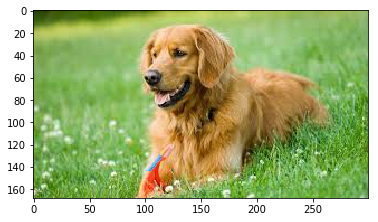

In [58]:
img = load_image('images/retr.jpg')
sal = visualize(img)

In [29]:
image = img
res_d, res_l = predict(normalize(image))
ans_label, accuracy = res_l[0]

input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
output = vgg(input)
output[0][int(ans_label)].backward()
grads = input.grad.data.clamp(min=0)
grads.squeeze()
grads.transpose_(0,1)
grads.transpose_(1,2)
grads = np.amax(grads.cpu().numpy(), axis=2)
grads = np.transpose(grads, (1,2,0))

print(grads)

[[[2.22220115e-04 4.53087641e-03 0.00000000e+00]
  [3.16126505e-04 1.24818273e-02 3.78886051e-03]
  [0.00000000e+00 2.25436911e-02 1.11393286e-02]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [1.84954086e-03 1.80453050e-03 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.51408545e-04]]

 [[2.25082552e-03 7.82778859e-03 9.60946083e-04]
  [0.00000000e+00 8.21457710e-03 3.11344769e-03]
  [0.00000000e+00 2.45877821e-02 1.64372474e-02]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [7.72248674e-03 1.16319945e-02 3.82276857e-03]
  [5.01125026e-03 7.99451582e-03 2.58058775e-03]]

 [[3.12136021e-03 9.30299517e-03 0.00000000e+00]
  [1.32581582e-02 3.49546820e-02 1.03132017e-02]
  [1.41226640e-02 4.59868982e-02 1.85979381e-02]
  ...
  [1.21061914e-02 2.36423854e-02 9.79700498e-03]
  [4.23140172e-03 9.60875489e-03 0.00000000e+00]
  [8.22626054e-04 9.63795581e-04 0.00000000e+00]]

 ...

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.0000